# 1. 스팸 메일 데이터에 대한 이해

import os
os.chdir('Data')

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import urllib.request
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
# 다운로드 받은 spam.csv 파일을 데이터프레임으로 로드하고 총 샘플의 수를 확인해봅시다.
# urllib.request.urlretrieve("https://raw.githubusercontent.com/ukairia777/tensorflow-nlp-tutorial/main/10.%20RNN%20Text%20Classification/dataset/spam.csv", filename="spam.csv")

In [6]:
data = pd.read_csv('spam.csv', encoding='latin1')
print('총 샘플의 수 :',len(data))

총 샘플의 수 : 5572


In [7]:
data.head(15)

v1                                                 v2 Unnamed: 2  \
0    ham  Go until jurong point, crazy.. Available only ...        NaN   
1    ham                      Ok lar... Joking wif u oni...        NaN   
2   spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3    ham  U dun say so early hor... U c already then say...        NaN   
4    ham  Nah I don't think he goes to usf, he lives aro...        NaN   
5   spam  FreeMsg Hey there darling it's been 3 week's n...        NaN   
6    ham  Even my brother is not like to speak with me. ...        NaN   
7    ham  As per your request 'Melle Melle (Oru Minnamin...        NaN   
8   spam  WINNER!! As a valued network customer you have...        NaN   
9   spam  Had your mobile 11 months or more? U R entitle...        NaN   
10   ham  I'm gonna be home soon and i don't want to tal...        NaN   
11  spam  SIX chances to win CASH! From 100 to 20,000 po...        NaN   
12  spam  URGENT! You have won a 1 week FREE membership ...        NaN   
13   ham  I've been searching for the right words to tha...        NaN   
14   ham                I HAVE A DATE ON SUNDAY WITH WILL!!        NaN   

   Unnamed: 3 Unnamed: 4  
0         NaN        NaN  
1         NaN        NaN  
2         NaN        NaN  
3         NaN        NaN  
4         NaN        NaN  
5         NaN        NaN  
6         NaN        NaN  
7         NaN        NaN  
8         NaN        NaN  
9         NaN        NaN  
10        NaN        NaN  
11        NaN        NaN  
12        NaN        NaN  
13        NaN        NaN  
14        NaN        NaN

In [8]:
# 컬럼 삭제
del data['Unnamed: 2']
del data['Unnamed: 3']
del data['Unnamed: 4']

data['v1'] = data['v1'].replace(['ham','spam'], [0, 1])
data[:5]

v1                                                 v2
0   0  Go until jurong point, crazy.. Available only ...
1   0                      Ok lar... Joking wif u oni...
2   1  Free entry in 2 a wkly comp to win FA Cup fina...
3   0  U dun say so early hor... U c already then say...
4   0  Nah I don't think he goes to usf, he lives aro...

In [9]:
data.info()  # null값 확인, 데이터 타입

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   v1      5572 non-null   int64 
 1   v2      5572 non-null   object
dtypes: int64(1), object(1)
memory usage: 87.2+ KB


In [10]:
print('결측값 여부 :', data.isnull().values.any())

결측값 여부 : False


In [11]:
print('v2열의 유니크한 값 :', data['v2'].nunique())

v2열의 유니크한 값 : 5169


In [12]:
print('v1열의 유니크한 값 :', data['v1'].nunique())

v1열의 유니크한 값 : 2


In [13]:
data['v1'].value_counts()

0    4825
1     747
Name: v1, dtype: int64

In [14]:
# v2 열(메일 내용)에서 중복인 내용이 있다면 중복 제거
data.drop_duplicates(subset=['v2'], inplace=True)
print('총 샘플의 수 :', len(data))

총 샘플의 수 : 5169


<AxesSubplot:>

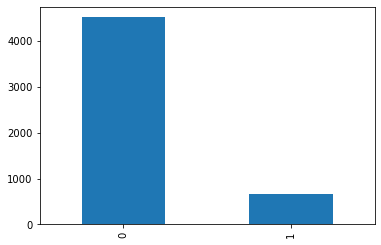

In [15]:
data['v1'].value_counts().plot(kind='bar')

In [16]:
print('정상 메일과 스팸 메일의 개수')
data.groupby('v1').size().reset_index(name='count')

정상 메일과 스팸 메일의 개수


v1  count
0   0   4516
1   1    653

In [17]:
data

v1                                                 v2
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
...   ..                                                ...
5567   1  This is the 2nd time we have tried 2 contact u...
5568   0              Will Ì_ b going to esplanade fr home?
5569   0  Pity, * was in mood for that. So...any other s...
5570   0  The guy did some bitching but I acted like i'd...
5571   0                         Rofl. Its true to its name

[5169 rows x 2 columns]

In [18]:
print(f'정상 메일의 비율 = {round(data["v1"].value_counts()[0]/len(data) * 100, 3)}%')
print(f'스팸 메일의 비율 = {round(data["v1"].value_counts()[1]/len(data) * 100, 3)}%')

정상 메일의 비율 = 87.367%
스팸 메일의 비율 = 12.633%


In [19]:
# v2열과 v1열을 X데이터와 y데이터라는 X_data, y_data로 저장합니다.
X_data = data['v2']
y_data = data['v1']

print('메일 본문의 개수: {}'.format(len(X_data)))
print('레이블의 개수: {}'.format(len(y_data)))

메일 본문의 개수: 5169
레이블의 개수: 5169


In [20]:
# 레이블 분포에 맞게 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0, stratify=y_data)

In [21]:
print('--------훈련 데이터의 비율-----------')
print(f'정상 메일 = {round(y_train.value_counts()[0]/len(y_train) * 100,3)}%')
print(f'스팸 메일 = {round(y_train.value_counts()[1]/len(y_train) * 100,3)}%')


--------훈련 데이터의 비율-----------
정상 메일 = 87.376%
스팸 메일 = 12.624%


In [22]:
print('--------테스트 데이터의 비율-----------')
print(f'정상 메일 = {round(y_test.value_counts()[0]/len(y_test) * 100,3)}%')
print(f'스팸 메일 = {round(y_test.value_counts()[1]/len(y_test) * 100,3)}%')

--------테스트 데이터의 비율-----------
정상 메일 = 87.331%
스팸 메일 = 12.669%


In [23]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_encoded = tokenizer.texts_to_sequences(X_train)

print(X_train_encoded[:5])

[[102, 1, 210, 230, 3, 17, 39], [1, 59, 8, 427, 17, 5, 137, 2, 2326], [157, 180, 12, 13, 98, 93, 47, 9, 40, 3485, 247, 8, 7, 87, 6, 80, 1312, 5, 3486, 7, 2327, 11, 660, 306, 20, 25, 467, 708, 1028, 203, 129, 193, 800, 2328, 23, 1, 144, 71, 2, 111, 78, 43, 2, 130, 11, 800, 186, 122, 1512], [1, 1154, 13, 104, 292], [222, 622, 857, 540, 623, 22, 23, 83, 10, 47, 6, 257, 32, 6, 26, 64, 936, 407]]


In [24]:
# 각 정수가 어떤 단어에 부여되었는지 확인해봅시다.
word_to_index = tokenizer.word_index
print(len(word_to_index))
print(word_to_index)

7821
{'i': 1, 'to': 2, 'you': 3, 'a': 4, 'the': 5, 'u': 6, 'and': 7, 'in': 8, 'is': 9, 'me': 10, 'my': 11, 'for': 12, 'your': 13, 'it': 14, 'of': 15, 'have': 16, 'on': 17, 'call': 18, 'that': 19, 'are': 20, '2': 21, 'now': 22, 'so': 23, 'but': 24, 'not': 25, 'can': 26, 'or': 27, "i'm": 28, 'get': 29, 'at': 30, 'do': 31, 'if': 32, 'be': 33, 'will': 34, 'just': 35, 'with': 36, 'we': 37, 'no': 38, 'this': 39, 'ur': 40, 'up': 41, '4': 42, 'how': 43, 'gt': 44, 'lt': 45, 'go': 46, 'when': 47, 'from': 48, 'what': 49, 'ok': 50, 'out': 51, 'know': 52, 'free': 53, 'all': 54, 'like': 55, 'then': 56, 'got': 57, 'good': 58, 'am': 59, 'time': 60, 'was': 61, 'come': 62, 'its': 63, 'love': 64, 'want': 65, 'text': 66, 'he': 67, 'only': 68, 'there': 69, 'day': 70, 'need': 71, 'going': 72, 'lor': 73, 'send': 74, 'one': 75, 'as': 76, 'home': 77, 'about': 78, 'back': 79, 'still': 80, 'k': 81, 'see': 82, 'txt': 83, 'by': 84, 'da': 85, 'stop': 86, 'r': 87, 'any': 88, 'tell': 89, 'dont': 90, "i'll": 91, "don'

In [25]:
threshold = 2   # 희귀 단어 기준
total_cnt = len(word_to_index) # 단어의 수
rare_cnt = 0    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0  # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0   # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 사전의 총 단어수: ', len(word_to_index))
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합(vocabulary)에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 사전의 총 단어수:  7821
등장 빈도가 1번 이하인 희귀 단어의 수: 4337
단어 집합(vocabulary)에서 희귀 단어의 비율: 55.45326684567191
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 6.65745644331875


In [26]:
# 패딩이 포함된 단어 사전 크기
vocab_size = len(word_to_index) + 1
print('단어 집합의 크기: {}'.format((vocab_size)))

단어 집합의 크기: 7822


메일의 최대 길이 : 189
메일의 평균 길이 : 15.754534


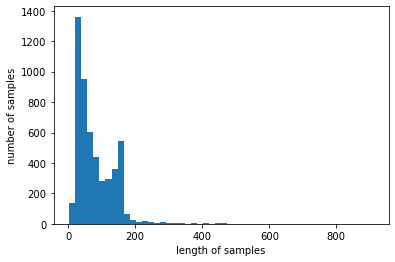

In [27]:
# 시각화
print('메일의 최대 길이 : %d' % max(len(sample) for sample in X_train_encoded))
print('메일의 평균 길이 : %f' % (sum(map(len, X_train_encoded))/len(X_train_encoded)))
plt.hist([len(sample) for sample in X_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [28]:
# 패딩 : 긴 텍스트는 자르고, 짧은 텍스트는 패딩을 더해서 늘리고.
max_len = 189
X_train_padded = pad_sequences(X_train_encoded, maxlen = max_len)
print("훈련 데이터의 크기(shape):", X_train_padded.shape)

훈련 데이터의 크기(shape): (4135, 189)


# 2. RNN으로 스팸 메일 분류하기

In [29]:
from tensorflow.keras.layers import SimpleRNN, Embedding, Dense
from tensorflow.keras.models import Sequential

embedding_dim = 64
hidden_units = 64

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=189))
model.add(SimpleRNN(hidden_units))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train_padded, y_train, epochs=13, batch_size=128, validation_split=0.2)

Epoch 1/13
26/26 [==============================] - 10s 180ms/step - loss: 0.3807 - acc: 0.8558 - val_loss: 0.3415 - val_acc: 0.8779
Epoch 2/13
26/26 [==============================] - 4s 162ms/step - loss: 0.1646 - acc: 0.9513 - val_loss: 0.2417 - val_acc: 0.9057
Epoch 3/13
26/26 [==============================] - 4s 150ms/step - loss: 0.0730 - acc: 0.9810 - val_loss: 0.0689 - val_acc: 0.9819
Epoch 4/13
26/26 [==============================] - 4s 148ms/step - loss: 0.0397 - acc: 0.9900 - val_loss: 0.0612 - val_acc: 0.9843
Epoch 5/13
26/26 [==============================] - 4s 151ms/step - loss: 0.0322 - acc: 0.9906 - val_loss: 0.0578 - val_acc: 0.9855
Epoch 6/13
26/26 [==============================] - 4s 146ms/step - loss: 0.0141 - acc: 0.9970 - val_loss: 0.0614 - val_acc: 0.9831
Epoch 7/13
26/26 [==============================] - 4s 169ms/step - loss: 0.0101 - acc: 0.9979 - val_loss: 0.0653 - val_acc: 0.9831
Epoch 8/13
26/26 [==============================] - 4s 148ms/step - loss: 0

In [30]:
X_test_encoded = tokenizer.texts_to_sequences(X_test)
X_test_padded = pad_sequences(X_test_encoded, maxlen = max_len)
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test_padded, y_test)[1]))

33/33 [==============================] - 1s 15ms/step - loss: 0.1355 - acc: 0.9662

 테스트 정확도: 0.9662


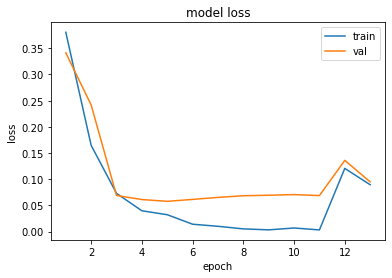

In [31]:
epochs = range(1, len(history.history['acc']) + 1)
plt.plot(epochs, history.history['loss'])
plt.plot(epochs, history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()